## A simple filter to remove masks from SAM predictions

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET

In [2]:
segmentation_folder_path = '../../data/courtright/segmentations/'
# assert if the folder exists
assert os.path.exists(segmentation_folder_path), "The folder does not exist"
segmentation_files = [os.path.join(segmentation_folder_path, f) for f in os.listdir(segmentation_folder_path) if f.endswith('.npy')]
print(segmentation_files[:5])

['../../data/courtright/segmentations/DJI_0650.npy', '../../data/courtright/segmentations/DJI_0596.npy', '../../data/courtright/segmentations/DJI_0681.npy', '../../data/courtright/segmentations/DJI_0708.npy', '../../data/courtright/segmentations/DJI_0811.npy']


In [3]:
segmentation_file = segmentation_files[0]
print(segmentation_file)
masks = np.load(segmentation_file)
# print the number of masks
print("Number of masks: ", np.max(masks)+1)

../../data/courtright/segmentations/DJI_0650.npy
Number of masks:  700


In [4]:
mask_sizes = []
for i in range(np.max(masks)+1):
    mask_sizes.append(np.sum(masks == i))

mask_sizes = np.array(mask_sizes)

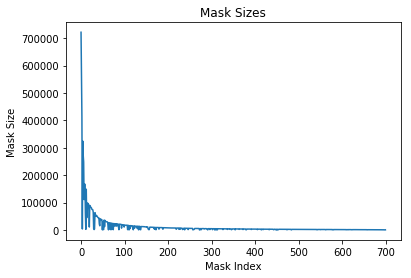

In [5]:
# plot a diagram of the mask sizes; the x-axis is the mask index and the y-axis is the size of the mask
plt.plot(mask_sizes)
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Mask Sizes')
plt.show()


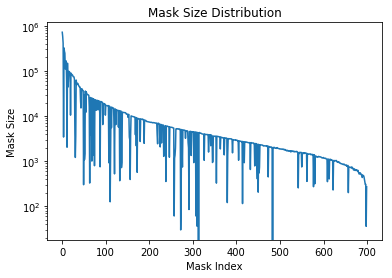

In [6]:
# plot a diagram of the mask sizes in log space; the x-axis is the mask index and the y-axis is the size of the mask
plt.plot(np.arange(0, np.max(masks)+1), mask_sizes)
plt.yscale('log')
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Mask Size Distribution')
plt.show()

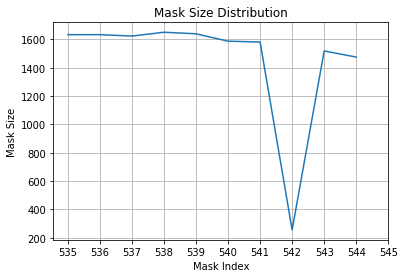

In [7]:
# plot a diagram of the first 20 mask sizes; add grid; x axis should be integers ranging from 0 to 20
plt.plot(np.arange(535, 545), mask_sizes[535:545])
# set x-axis to be integers
plt.xticks(np.arange(535, 546, 1))
plt.grid()
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Mask Size Distribution')
plt.show()

In [8]:
# plot the first 100 masks
"""
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(masks == i*10+j)
        ax[i, j].axis('off')
plt.show()
"""

"\nfig, ax = plt.subplots(10, 10, figsize=(20, 20))\nfor i in range(10):\n    for j in range(10):\n        ax[i, j].imshow(masks == i*10+j)\n        ax[i, j].axis('off')\nplt.show()\n"

## Moving average window filter

In [9]:
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')


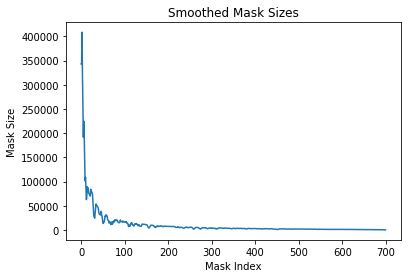

In [10]:
# Apply moving average with a window size 
smoothed_mask_sizes = moving_average(mask_sizes, 5)

# plot the smoothed mask sizes
plt.plot(smoothed_mask_sizes)
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Smoothed Mask Sizes')
plt.show()

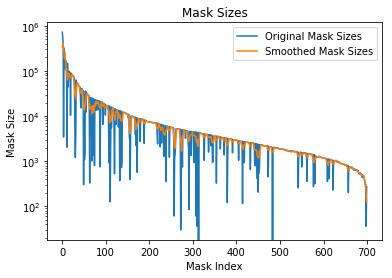

In [11]:
# plot the smoothed mask sizes and the original mask sizes in the same plot
plt.plot(mask_sizes, label='Original Mask Sizes')
plt.plot(smoothed_mask_sizes, label='Smoothed Mask Sizes')
# y in log space
plt.yscale('log')
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Mask Sizes')
plt.legend()
plt.show()


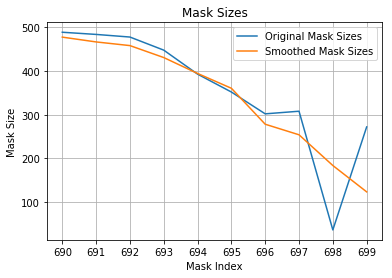

In [12]:
x1 = 690
x2 = 700
plt.plot(np.arange(x1, x2, 1), mask_sizes[x1:x2], label='Original Mask Sizes')
plt.plot(np.arange(x1, x2, 1), smoothed_mask_sizes[x1:x2], label='Smoothed Mask Sizes')
# y in log space
# get x axis to be integers 
plt.grid()
plt.xticks(np.arange(x1, x2, 1))
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Mask Sizes')
plt.legend()
plt.show()

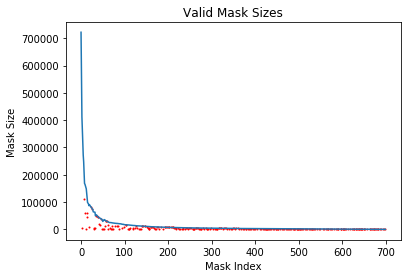

In [13]:
# get the mask ids where the mask size is greater than smoothed mask size
valid_masks_id = np.where(mask_sizes > smoothed_mask_sizes)[0]
valid_masks_size = mask_sizes[valid_masks_id]

invalid_masks_id = np.where(mask_sizes <= smoothed_mask_sizes)[0]
invalid_masks_size = mask_sizes[invalid_masks_id]
# plot the valid mask sizes
plt.plot(valid_masks_id, valid_masks_size)
# scatter plot the invalid mask sizes with red color and smaller size
plt.scatter(invalid_masks_id, invalid_masks_size, color='red', s=1)
plt.xlabel('Mask Index')
plt.ylabel('Mask Size')
plt.title('Valid Mask Sizes')
plt.show()

In [14]:
# get ratio of valid masks
ratio = len(valid_masks_id) / (len(valid_masks_id) + len(invalid_masks_id))
print("Ratio of valid masks: ", ratio)

Ratio of valid masks:  0.6014285714285714


In [27]:
len(valid_masks_id) 

421

## Object size filter

In [15]:
depth_file_path = '../../data/courtright/associations/depth/DJI_0650.npy' 
assert os.path.exists(depth_file_path), "The file does not exist"
depth_image = np.load(depth_file_path)
# replace inf with 0
depth_image[np.isinf(depth_image)] = 0

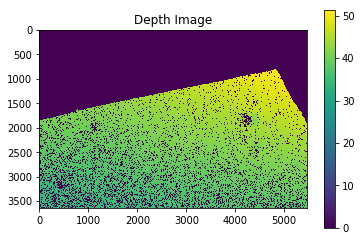

In [16]:
# plot depth image
plt.imshow(depth_image)
plt.colorbar()
plt.title('Depth Image')
plt.show()

In [17]:
# read camera parameters
camera_file_path = '../../data/courtright/SfM_products/agisoft_cameras.xml'

def read_camera_parameters_agisoft(file_path):
    # check if the file exists
    assert os.path.exists(file_path)

    cameras = dict()

    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract image dimensions
    image_dimensions = root.find('.//ImageDimensions')
    width = int(image_dimensions.find('Width').text)
    height = int(image_dimensions.find('Height').text)

    cameras['width'] = width
    cameras['height'] = height

    # Get camera intrinsics
    sensor_diagonal_mm = root.find('.//SensorSize').text
    focal_length_mm = root.find('.//FocalLength').text

    # Convert camera intrinsics to meters
    sensor_diagonal_m = float(sensor_diagonal_mm) / 1000
    focal_length_m = float(focal_length_mm) / 1000

    # Calculate aspect ratio
    aspect_ratio = width / height

    # Calculate sensor width and height using aspect ratio and diagonal
    sensor_height = np.sqrt(sensor_diagonal_m**2 / (1 + aspect_ratio**2))
    sensor_width = aspect_ratio * sensor_height

    # Calculate pixel size
    pixel_size_width = sensor_width / width
    pixel_size_height = sensor_height / height

    pixel_size_m = np.sqrt(pixel_size_width * pixel_size_height) 

    return focal_length_m, pixel_size_m

focal_length, sensor_size = read_camera_parameters_agisoft(camera_file_path)
print("Focal Length: ", focal_length)
print("Sensor Size: ", sensor_size)

Focal Length:  0.010689196654678247
Sensor Size:  2.005835530993016e-06


In [18]:
def create_surface_area_image(depth_image, focal_length, pixel_size):
    # Calculate the surface area for each pixel
    area_per_pixel = ((depth_image / focal_length) ** 2) * (pixel_size ** 2)
    return area_per_pixel

def calculate_masked_area(area_image, masks, id):
    mask = masks == id
    masked_area = np.sum(area_image[mask])
    return masked_area


area_image = create_surface_area_image(depth_image, focal_length, sensor_size)

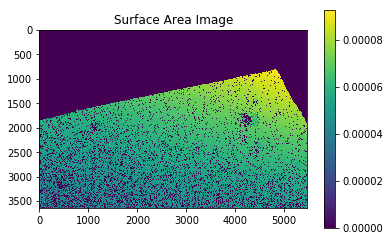

In [19]:
# plot the area image
plt.imshow(area_image)
plt.colorbar()
plt.title('Surface Area Image')
plt.show()

In [20]:
mask_areas = []
for i in range(np.max(masks)+1):
    mask_areas.append(calculate_masked_area(area_image, masks, i))

mask_areas = np.array(mask_areas)

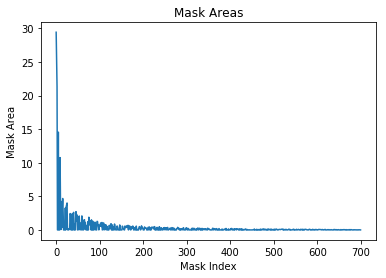

In [21]:
# plot the mask areas
plt.plot(mask_areas)
plt.xlabel('Mask Index')
plt.ylabel('Mask Area')
plt.title('Mask Areas')
plt.show()

Number of valid masks:  421


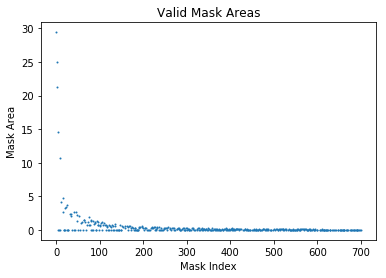

In [22]:
# keep the masks with valid_masks_id
valid_mask_areas = mask_areas[valid_masks_id]

print("Number of valid masks: ", len(valid_masks_id))

# plot the valid mask areas
plt.scatter(valid_masks_id, valid_mask_areas, s=1)
# y in log space
# plt.yscale('log')
plt.xlabel('Mask Index')
plt.ylabel('Mask Area')
plt.title('Valid Mask Areas')
plt.show()

Number of valid masks after filtering:  220


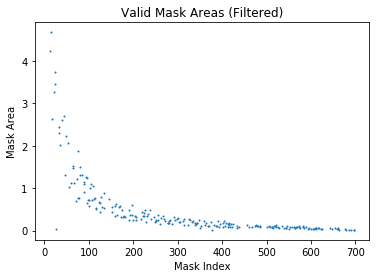

In [23]:
# apply area filter using upper and lower bounds
upper_bound = 9
lower_bound = 0.1*0.1
valid_mask_areas = np.array(valid_mask_areas)
valid_masks_id_filtered = valid_masks_id[np.where((valid_mask_areas > lower_bound) & (valid_mask_areas < upper_bound))]
valid_mask_areas_filtered = valid_mask_areas[np.where((valid_mask_areas > lower_bound) & (valid_mask_areas < upper_bound))]
print("Number of valid masks after filtering: ", len(valid_masks_id_filtered))

# plot the valid mask areas after filtering
plt.scatter(valid_masks_id_filtered, valid_mask_areas_filtered, s=1)
plt.xlabel('Mask Index')
plt.ylabel('Mask Area')
plt.title('Valid Mask Areas (Filtered)')
plt.show()

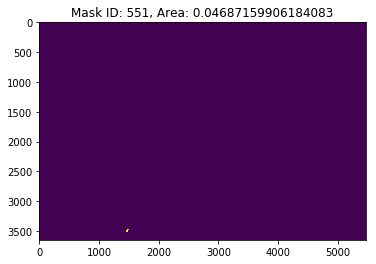

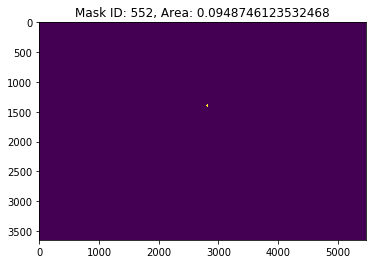

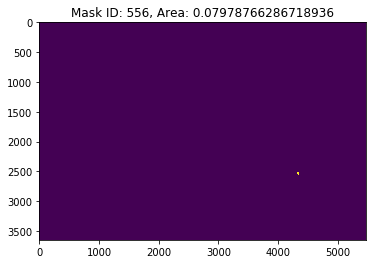

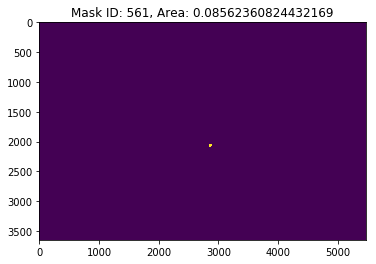

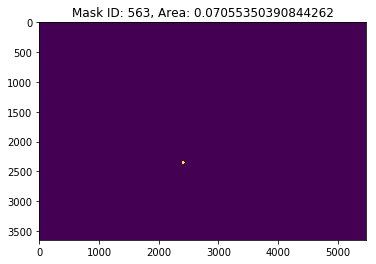

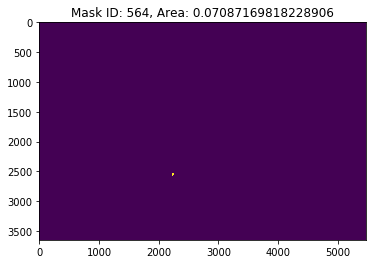

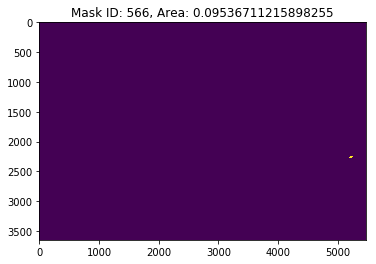

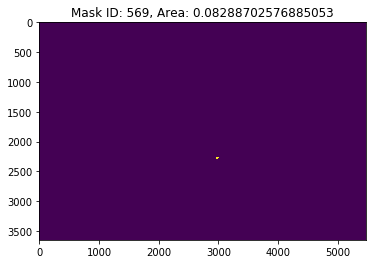

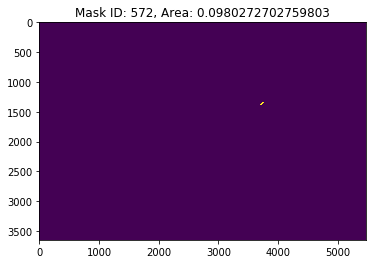

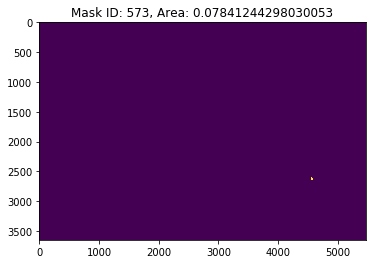

In [24]:
# plot mask given an mask id
def plot_mask(masks, id):
    mask = masks == id
    area = calculate_masked_area(area_image, masks, id)
    plt.imshow(mask)
    plt.title('Mask ID: ' + str(id) + ', Area: ' + str(area))
    plt.show()

# plot first 10 masks
for i in range(180,190):
    id = valid_masks_id_filtered[i]
    plot_mask(masks, id)

In [28]:
import numpy as np
import os
f = "../../data/courtright/segmentations_filtered/DJI_0650.npy"
assert os.path.exists(f)
masks = np.load(f)

In [29]:
# get the number of unique ids in the masks
unique_ids = np.unique(masks)
print("Number of unique ids: ", len(unique_ids))

Number of unique ids:  221
